In [1]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math
from PIL import Image
from collections import deque
import numpy as np
from scipy.ndimage import maximum_filter, minimum_filter, label, generate_binary_structure


/home/lingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def color_clustering(image):
    """
    Identifica regiones conectadas por color en 'image'.
    Asume que 'image' es una matriz 2D con valores de color.
    Retorna una matriz 'clusters' con un ID de cluster para cada píxel.
    """
    rows, cols = image.shape
    visited = np.zeros_like(image, dtype=bool)
    clusters = np.zeros_like(image, dtype=np.int32)
    cluster_id = 0

    # Direcciones para explorar (arriba, abajo, izquierda, derecha)
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    for r in range(rows):
        for c in range(cols):
            if not visited[r,c]:
                cluster_id += 1
                color = image[r,c]
                queue = deque([(r,c)])
                visited[r,c] = True
                clusters[r,c] = cluster_id

                # BFS para etiquetar todos los píxeles conectados del mismo color
                while queue:
                    rr, cc = queue.popleft()
                    for dr, dc in directions:
                        nr, nc = rr + dr, cc + dc
                        if 0 <= nr < rows and 0 <= nc < cols:
                            if not visited[nr,nc] and image[nr,nc] == color:
                                visited[nr,nc] = True
                                clusters[nr,nc] = cluster_id
                                queue.append((nr,nc))

    return clusters

def detectar_bordes(matriz):
    """
    Retorna una matriz booleana donde True indica píxeles
    que forman el borde de la región (1) en 'matriz'.
    """
    rows, cols = matriz.shape
    bordes = np.zeros_like(matriz, dtype=bool)
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for r in range(rows):
        for c in range(cols):
            if matriz[r,c] != 0:  # parte de la región
                for dr, dc in directions:
                    nr, nc = r+dr, c+dc
                    # Si sale de la matriz o es 0, es borde
                    if not (0 <= nr < rows and 0 <= nc < cols) or matriz[nr,nc] == 0:
                        bordes[r,c] = True
                        break
    return bordes

def es_fosa(cluster_distribution, cluster_id, pixels):
    """
    Determina si 'cluster_id' está rodeado solo por clusters
    con valor mayor en 'pixels', y no toca el borde de la matriz.
    """
    rows, cols = cluster_distribution.shape
    mask_c = (cluster_distribution == cluster_id)

    # Verificar si el cluster toca el borde de la matriz
    if (np.any(mask_c[0, :]) or 
        np.any(mask_c[rows-1, :]) or 
        np.any(mask_c[:, 0]) or 
        np.any(mask_c[:, cols-1])):
        return False  # Si toca el borde, no es fosa

    # Intensidad media del cluster
    avg_c = np.mean(pixels[mask_c])

    # Detectar bordes del cluster (matriz binaria 0/1)
    bordes_c = detectar_bordes(mask_c.astype(int))

    directions = [(1,0), (-1,0), (0,1), (0,-1)]
    vecinos = set()

    # Buscar clusters vecinos a lo largo del borde del cluster
    for r in range(rows):
        for c in range(cols):
            if bordes_c[r,c]:
                for dr, dc in directions:
                    nr, nc = r+dr, c+dc
                    if 0 <= nr < rows and 0 <= nc < cols:
                        cluster_vecino = cluster_distribution[nr, nc]
                        if cluster_vecino != cluster_id:
                            vecinos.add(cluster_vecino)

    # Verificar que todos los clusters vecinos tengan intensidad mayor
    for v in vecinos:
        mask_v = (cluster_distribution == v)
        if np.mean(pixels[mask_v]) <= avg_c:
            return False

    return True

def sumar_areas_fosas(pixels):
    """
    Retorna la suma total de las áreas de todos los clusters considerados fosas.
    """
    # Se asume que existe la función 'color_clustering' que genera la matriz de clusters
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(pixels))))
    cluster_distribution = color_clustering(pixels)
    ids = np.unique(cluster_distribution)

    total_area_fosas = 0
    for cluster_id in ids:
        if es_fosa(cluster_distribution, cluster_id, pixels):
            total_area_fosas += np.sum(cluster_distribution == cluster_id)

    return total_area_fosas

In [3]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [4]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))

'''
image = Image.open("metal_dataset/test/Pitted/PS_108.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))
'''
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [5]:
image = Image.open("metal_dataset/test/Pitted/PS_108.bmp")
original_width, original_height = image.size
scale = 0.5
image = image.resize((max(1, int(original_width * scale)), max(1, int(original_height * scale))))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(np.array(image)))

In [6]:
def optimize_image(image, n_tries: int = 100):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 1.0, 100.0)  # Spatial window radius
        sr = trial.suggest_float("sr", sp, 100.0)  # Color window radius
        k = trial.suggest_int("k", 5.0, 30.0)
        # Apply mean shift filtering
        after = Perspectiver.kmeansClustering(Perspectiver.meanShift(image, sp, sr), k=k)

        return sumar_areas_fosas(after)/k

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }

In [7]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [8]:
BEST = optimize_image(original_image, n_tries=200)["best_params"]
BEST

[I 2025-02-04 20:05:52,578] A new study created in memory with name: no-name-24baffa7-c413-4d0f-aab9-6e5420b6d514


Using 6 CPU threads for parallel optimization.


[I 2025-02-04 20:05:52,835] Trial 3 finished with value: 94.0 and parameters: {'sp': 76.16896601880556, 'sr': 77.86170993713466, 'k': 7}. Best is trial 3 with value: 94.0.
[I 2025-02-04 20:05:53,908] Trial 1 finished with value: 126.0 and parameters: {'sp': 48.390109311489304, 'sr': 49.14339476844558, 'k': 13}. Best is trial 1 with value: 126.0.
[I 2025-02-04 20:05:54,113] Trial 4 finished with value: 46.0 and parameters: {'sp': 20.804191664039948, 'sr': 87.56833123950871, 'k': 29}. Best is trial 1 with value: 126.0.
[I 2025-02-04 20:05:54,187] Trial 6 finished with value: 171.0 and parameters: {'sp': 23.312173338427257, 'sr': 27.667209899431136, 'k': 5}. Best is trial 6 with value: 171.0.
[I 2025-02-04 20:05:54,871] Trial 2 finished with value: 439.0 and parameters: {'sp': 69.31243416405296, 'sr': 79.27591774558896, 'k': 15}. Best is trial 2 with value: 439.0.
[I 2025-02-04 20:05:56,663] Trial 8 finished with value: 73.0 and parameters: {'sp': 1.0333243505370642, 'sr': 47.157979326895

KeyboardInterrupt: 

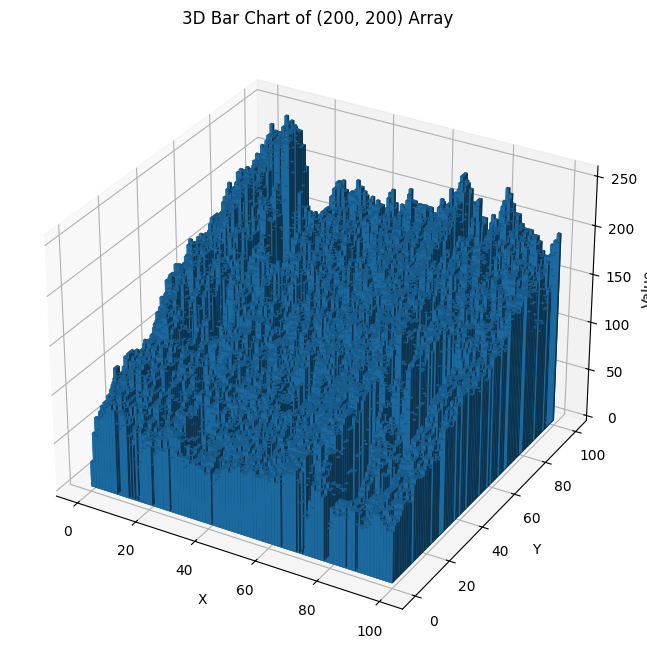

In [ ]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

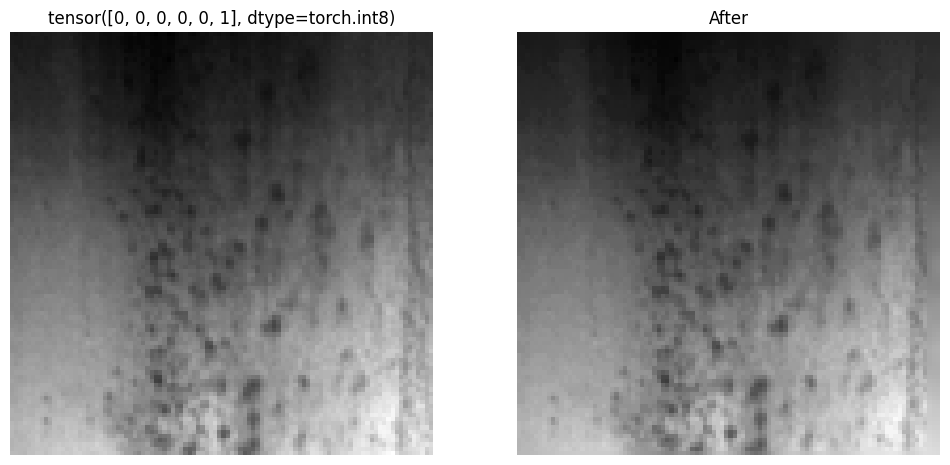

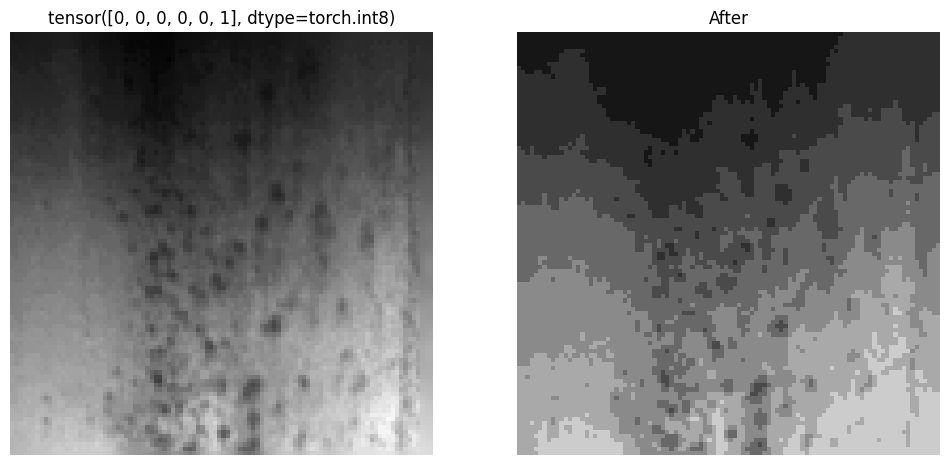

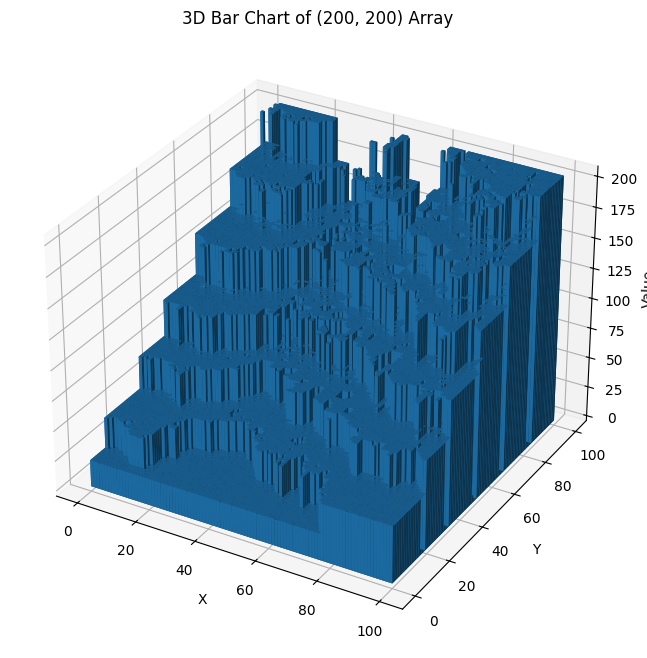

np.float64(44.714285714285715)

In [ ]:
#clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
clustered_image = Perspectiver.meanShift(original_image, 5, 6)
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)

#kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = BEST["k"])
kmeans_image = Perspectiver.kmeansClustering(clustered_image, k = 7)
Perspectiver.plotComparison(clustered_image, kmeans_image, titleBefore=label)

plot_barchartImage(Perspectiver.rgb_to_grayscale(kmeans_image))
Perspectiver.evaluate_clustering(original_image, kmeans_image)
sumar_areas_fosas(kmeans_image)/7

In [63]:
def transformar_matriz(matriz):
    """
    Transforma una matriz con valores en [0,255] a una de [0,127].
    Si el valor <= 127 se mantiene, y si > 127 se mapea linealmente:
    127 -> 127 y 255 -> 0.
    """
    # Convertir a flotante para cálculos precisos
    out = matriz.astype(np.float32).copy()
    # Crear máscara para los valores mayores que 127
    mask = out > 127
    # Aplicar transformación lineal a los valores superiores a 127
    out[mask] = 127 - (out[mask] - 127) * (127 / 128)
    # Redondear y convertir a entero sin signo (0-255)
    return np.round(out).astype(np.uint8)

def distancia_minima_vecinos(arr):
    """
    Calcula para cada elemento la distancia mínima al vecino inmediato.
    En los extremos se usa el único vecino.
    """
    arr = np.array(arr)
    n = arr.size
    if n < 2:
        return np.zeros_like(arr)
    
    # Diferencias absolutas entre elementos adyacentes.
    dif = np.abs(np.diff(arr))
    
    # Inicializar el resultado.
    res = np.empty(n, dtype=arr.dtype)
    res[0] = dif[0]       # Primer elemento: sólo tiene el vecino derecho.
    res[-1] = dif[-1]     # Último elemento: sólo tiene el vecino izquierdo.
    
    # Para los elementos intermedios, se toma el mínimo de la diferencia con el vecino izquierdo y derecho.
    res[1:-1] = np.minimum(dif[:-1], dif[1:])
    
    return res

def distance_vector(clusters):
    ret = []
    for i in range(len(clusters)):
        if i == 0: ret.append(np.abs(clusters[i]-clusters[i+1]))
        if i == (len(clusters) - 1): ret.append(np.abs(clusters[i]-clusters[i-1]))
        else: ret.append(min(np.abs(clusters[i]-clusters[i-1]), np.abs(clusters[i]-clusters[i+1])))
    return ret

def plot_zonas_picos(matriz, umbral=None):
    """
    Detecta zonas de cambios bruscos (picos) en una matriz 2D mediante la magnitud del gradiente.
    Plotea la matriz en escala de grises y marca en azul los puntos donde la magnitud del gradiente
    supera el umbral definido.
    
    Parámetros:
      matriz: array 2D de entrada.
      umbral: valor umbral para considerar un cambio brusco. Si es None, se usa 80% del máximo.
    """
    # Calcular gradiente en las direcciones y (filas) y x (columnas)
    grad_y, grad_x = np.gradient(matriz.astype(float))
    # Magnitud del gradiente
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    
    # Definir umbral: 80% del máximo de la magnitud, si no se proporciona uno
    if umbral is None:
        umbral = 0.2 * np.max(grad_mag)
    
    # Índices donde la magnitud del gradiente supera el umbral
    indices = np.nonzero(grad_mag > umbral)
    
    # Plotear la imagen y superponer los puntos con cambios bruscos en azul
    plt.figure(figsize=(8, 6))
    plt.imshow(matriz, cmap='gray')
    plt.scatter(indices[1], indices[0], s=80, facecolors='none', edgecolors='blue', label='Zona de picos')
    plt.title("Zonas de picos (cambios bruscos) en azul")
    plt.legend()
    plt.show()

def variacion_media(arr):
    media = sum(arr) / len(arr)
    return sum(abs(x - media) for x in arr) / len(arr)

def plotear_imagen(array2d):
    """
    Plotea un array 2D como imagen en escala de grises.
    """
    plt.imshow(array2d, cmap='gray')
    plt.colorbar()  # Barra de color para referencia de intensidades
    plt.title("Imagen 2D")
    plt.show()

def encontrar_picos_y_fosas(matriz):
    """
    Detecta y cuenta picos y fosas en una matriz 2D.
    Un pico es una celda que es mayor o igual a todos sus vecinos (8-conectividad).
    Una fosa es una celda que es menor o igual a todos sus vecinos (8-conectividad).
    Retorna: (num_picos, picos_etiquetados, num_fosas, fosas_etiquetadas)
    """
    # Estructura para conectividad 8
    estructura = generate_binary_structure(2, 2)
    
    # Detectar picos: máximo local igual al valor de la celda
    max_local = maximum_filter(matriz, footprint=estructura) == matriz
    picos_etiquetados, num_picos = label(max_local, structure=estructura)
    
    # Detectar fosas: mínimo local igual al valor de la celda
    min_local = minimum_filter(matriz, footprint=estructura) == matriz
    fosas_etiquetadas, num_fosas = label(min_local, structure=estructura)
    
    return num_picos, picos_etiquetados, num_fosas, fosas_etiquetadas

def plot_picos_y_fosas(matriz):
    """
    Plotea la matriz en escala de grises y marca:
      - Picos en verde: celda > todos sus vecinos (8-conectividad)
      - Fosas en rojo:  celda < todos sus vecinos (8-conectividad)
    Se utiliza una vecindad de 3x3 sin incluir la celda central.
    """
    # Huella de la vecindad (excluye la celda central)
    footprint = np.array([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]], dtype=bool)
    
    # Picos: celda estrictamente mayor que el máximo de sus vecinos
    vecinos_max = maximum_filter(matriz, footprint=footprint, mode='constant', cval=-np.inf)
    picos_mask = matriz > vecinos_max
    picos_idx = np.nonzero(picos_mask)
    
    # Fosas: celda estrictamente menor que el mínimo de sus vecinos
    vecinos_min = minimum_filter(matriz, footprint=footprint, mode='constant', cval=np.inf)
    fosas_mask = matriz < vecinos_min
    fosas_idx = np.nonzero(fosas_mask)
    
    # Plotear la imagen y superponer los picos y fosas
    plt.imshow(matriz, cmap='gray')
    plt.scatter(picos_idx[1], picos_idx[0], s=80, facecolors='none', edgecolors='green', label='Picos')
    plt.scatter(fosas_idx[1], fosas_idx[0], s=80, facecolors='none', edgecolors='red', label='Fosas')
    plt.title("Picos (verde) y Fosas (rojo)")
    plt.legend()
    plt.show()
    
from collections import deque

def color_clustering(image):
    """
    Identifica regiones conectadas por color en 'image'.
    Asume que 'image' es una matriz 2D con valores de color.
    Retorna una matriz 'clusters' con un ID de cluster para cada píxel.
    """
    rows, cols = image.shape
    visited = np.zeros_like(image, dtype=bool)
    clusters = np.zeros_like(image, dtype=np.int32)
    cluster_id = 0

    # Direcciones para explorar (arriba, abajo, izquierda, derecha)
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    for r in range(rows):
        for c in range(cols):
            if not visited[r,c]:
                cluster_id += 1
                color = image[r,c]
                queue = deque([(r,c)])
                visited[r,c] = True
                clusters[r,c] = cluster_id

                # BFS para etiquetar todos los píxeles conectados del mismo color
                while queue:
                    rr, cc = queue.popleft()
                    for dr, dc in directions:
                        nr, nc = rr + dr, cc + dc
                        if 0 <= nr < rows and 0 <= nc < cols:
                            if not visited[nr,nc] and image[nr,nc] == color:
                                visited[nr,nc] = True
                                clusters[nr,nc] = cluster_id
                                queue.append((nr,nc))

    return clusters

In [99]:
import numpy as np
from collections import deque

def color_clustering(image):
    """
    Identifica regiones conectadas por color en 'image'.
    Asume que 'image' es una matriz 2D con valores de color.
    Retorna una matriz 'clusters' con un ID de cluster para cada píxel.
    """
    rows, cols = image.shape
    visited = np.zeros_like(image, dtype=bool)
    clusters = np.zeros_like(image, dtype=np.int32)
    cluster_id = 0

    # Direcciones para explorar (arriba, abajo, izquierda, derecha)
    directions = [(1,0), (-1,0), (0,1), (0,-1)]

    for r in range(rows):
        for c in range(cols):
            if not visited[r,c]:
                cluster_id += 1
                color = image[r,c]
                queue = deque([(r,c)])
                visited[r,c] = True
                clusters[r,c] = cluster_id

                # BFS para etiquetar todos los píxeles conectados del mismo color
                while queue:
                    rr, cc = queue.popleft()
                    for dr, dc in directions:
                        nr, nc = rr + dr, cc + dc
                        if 0 <= nr < rows and 0 <= nc < cols:
                            if not visited[nr,nc] and image[nr,nc] == color:
                                visited[nr,nc] = True
                                clusters[nr,nc] = cluster_id
                                queue.append((nr,nc))

    return clusters

def detectar_bordes(matriz):
    """
    Retorna una matriz booleana donde True indica píxeles
    que forman el borde de la región (1) en 'matriz'.
    """
    rows, cols = matriz.shape
    bordes = np.zeros_like(matriz, dtype=bool)
    directions = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    for r in range(rows):
        for c in range(cols):
            if matriz[r,c] != 0:  # parte de la región
                for dr, dc in directions:
                    nr, nc = r+dr, c+dc
                    # Si sale de la matriz o es 0, es borde
                    if not (0 <= nr < rows and 0 <= nc < cols) or matriz[nr,nc] == 0:
                        bordes[r,c] = True
                        break
    return bordes

def es_fosa(cluster_distribution, cluster_id, pixels):
    """
    Determina si 'cluster_id' está rodeado solo por clusters
    con valor mayor en 'pixels'.
    """
    mask_c = (cluster_distribution == cluster_id)
    avg_c = np.mean(pixels[mask_c])  # Intensidad media del cluster

    # Detectar bordes del cluster actual (matriz binaria 0/1 para el cluster)
    bordes = detectar_bordes(mask_c.astype(int))

    directions = [(1,0), (-1,0), (0,1), (0,-1)]
    rows, cols = cluster_distribution.shape
    vecinos = set()

    # Buscar clusters vecinos a lo largo del borde
    for r in range(rows):
        for c in range(cols):
            if bordes[r,c]:
                for dr, dc in directions:
                    nr, nc = r+dr, c+dc
                    if 0 <= nr < rows and 0 <= nc < cols:
                        cluster_vecino = cluster_distribution[nr, nc]
                        if cluster_vecino != cluster_id:
                            vecinos.add(cluster_vecino)

    # Verificar que todos los vecinos tengan intensidad mayor
    for v in vecinos:
        mask_v = (cluster_distribution == v)
        if np.mean(pixels[mask_v]) <= avg_c:
            return False

    return True

def sumar_areas_fosas(pixels):
    """
    Retorna la suma total de las áreas de todos los clusters considerados fosas.
    """
    # Se asume que existe la función 'color_clustering' que genera la matriz de clusters
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(pixels))))
    cluster_distribution = color_clustering(pixels)
    ids = np.unique(cluster_distribution)

    total_area_fosas = 0
    for cluster_id in ids:
        if es_fosa(cluster_distribution, cluster_id, pixels):
            total_area_fosas += np.sum(cluster_distribution == cluster_id)

    return total_area_fosas


sumar_areas_fosas(kmeans_image)

np.int64(1401)

In [81]:
def anormal_ratio(image):
    pixels = np.uint8(np.round(Perspectiver.rgb_to_grayscale(Perspectiver.normalize_to_uint8(image))))
    print(f"Imagen entrante: \n {pixels}")
    #pixels = transformar_matriz(pixels)
    plotear_imagen(pixels)

    cluster_distribution = color_clustering(pixels)
    clusters = np.unique(cluster_distribution)
    print(f"Clusters: {max(clusters)}, distribucion: \n {cluster_distribution} ")

    
    plot_zonas_picos(pixels)

Imagen entrante: 
 [[  0   0  49 ...   0   0   0]
 [  0   0  49 ...   0   0   0]
 [  0   0  49 ...   0   0   0]
 ...
 [197 255 255 ... 197 197 197]
 [255 255 255 ... 197 197 197]
 [255 255 255 ... 197 197 197]]


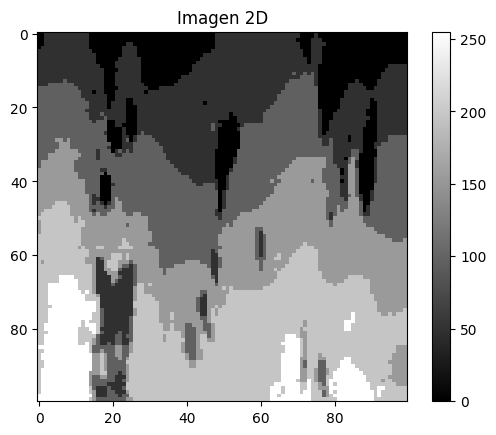

Clusters: 156, distribucion: 
 [[  1   1   2 ...   5   5   5]
 [  1   1   2 ...   5   5   5]
 [  1   1   2 ...   5   5   5]
 ...
 [121  83  83 ...  67  67  67]
 [ 83  83  83 ...  67  67  67]
 [ 83  83  83 ...  67  67  67]] 


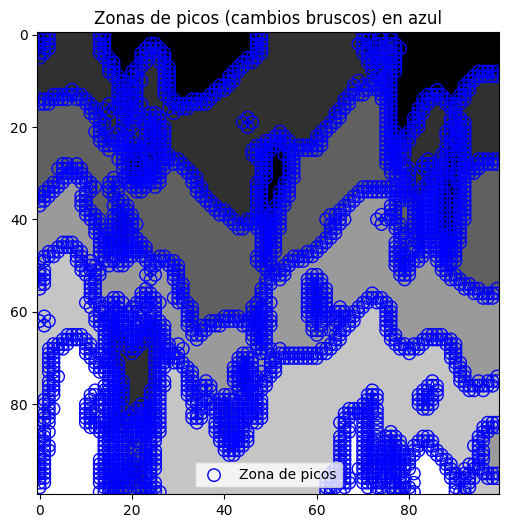

In [82]:
anormal_ratio(kmeans_image)